In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
#%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figure!


sns.set() # better looking figs


In [2]:
# our own set of small helper functions for plotting, etc
from utils import plot_embedding, plot_compare_embeddings, show_heatmap, plot_confusion_matrix

In [3]:
df = pd.read_csv("questionnaire-answers-per-clip.csv")
constructs=df.T.iloc[7:].T.columns
df.shape[0]/20/2

13.8

*we define here several useful partial views of the main dataframe*

In [4]:
fullscene_df=df[df["condition"]==4] # full scene

# the responses to the 22 Likert-scale questions
fullscene_ratings_df=fullscene_df.T.iloc[7:].T.astype(float)
fullscene=fullscene_ratings_df.values # the underlying numpy array

# clip names
fullscene_labels=fullscene_df["clipName"].values

# mean ratings per clip
fullscene_means=fullscene_df.groupby(["clipName"]).mean().T.iloc[6:].T


skel_df=df[df["condition"]==2] # skeleton

# the responses to the 22 Likert-scale questions
skel_ratings_df=skel_df.T.iloc[7:].T.astype(float)
skel=skel_ratings_df.values # the underlying numpy array

# clip names
skel_labels=skel_df["clipName"].values

# mean ratings per clip
skel_means=skel_df.groupby(["clipName"]).mean().T.iloc[6:].T

In [5]:
fullscene_ratings_per_clips_df=pd.concat([fullscene_df["clipName"],fullscene_ratings_df],axis=1)
meanvar_full_ratings=fullscene_ratings_per_clips_df.groupby("clipName").std().T.mean()

skel_ratings_per_clips_df=pd.concat([skel_df["clipName"],skel_ratings_df],axis=1)
meanvar_skel_ratings=skel_ratings_per_clips_df.groupby("clipName").std().T.mean()
pd.DataFrame([meanvar_full_ratings,meanvar_skel_ratings],index=["mean stddev fullscene ratings","mean stddev skel ratings"]).T

,mean stddev fullscene ratings,mean stddev skel ratings
clipName,,
1Laugh1PushAway,1.208202,1.215638
1Laughing,1.056700,1.068669
1PushBothExcited,1.041291,1.058527
1PushesHand,1.211459,0.954672
1StopsOtherPlay,1.136837,1.152276
1Task1Watch,1.186265,1.222791
bothDistressedTable,1.079581,1.060590
discussAndTogether,0.953305,1.105558
excitedChild,1.115183,1.051955


In [6]:
import krippendorff

krip={}

for clipName, group in fullscene_ratings_per_clips_df.groupby("clipName"):
    krip[clipName]=(krippendorff.alpha(group.values[:,1:].astype(int),level_of_measurement='interval'), group.shape[0])

for clipName, group in skel_ratings_per_clips_df.groupby("clipName"):
    krip[clipName]=krip[clipName] + (krippendorff.alpha(group.values[:,1:].astype(int),level_of_measurement='interval'), group.shape[0])

    
krippendorff_df=pd.DataFrame.from_dict(krip,orient="index", columns=["alpha(fullscene)", "N(fullscene)", "alpha(skel)", "N(skel)"])
show_heatmap(krippendorff_df[["alpha(fullscene)", "alpha(skel)"]])


,alpha(fullscene),alpha(skel)
1Laugh1PushAway,0.211374,0.192624
1Laughing,0.395178,0.234177
1PushBothExcited,0.346956,0.226377
1PushesHand,0.227074,0.389097
1StopsOtherPlay,0.185309,0.12143
1Task1Watch,0.351601,0.151658
bothDistressedTable,0.362346,0.201604
discussAndTogether,0.42769,0.172804
excitedChild,0.237514,0.171145
independent,0.280106,0.281602


# Latent constructs

The first step of the analysis looks at latent constructs.

Our initial data contains responses to 22 questions (ie, 22 degrees of freedom). The question is: can those 22 DoFs be grouped into a smaller number of *latent* constructs that would effectively encapsulate the differences observed in the reponses between video clips.

Three approaches are explored:
- Principal component analysis (PCA)
- Principal component analysis (purely for dimensionality reduction) followed by a linear discriminant analysis (LDA) that aims at maximising inter-class distances (ie, inter-clips ratings) while minimizing intra-class distances (ie, the differences between ratings for a given clip).
- Explorative Factor Analysis (EFA)

## PCA

In [7]:
from sklearn.decomposition import PCA

We compute the PCA transformation with the responses to the *fullscene* stimuli.

We then project both the *fullscene* and the *skeletal-only* responses in this PCA space, effectively reducing the dimensionality of our data from 22 to `nb_components` (ie, 6).

In [8]:
nb_components = 6

fullscene_pca_model=PCA(n_components=nb_components).fit(fullscene)

fullscene_pca = fullscene_pca_model.transform(fullscene)
fullscene_means_pca = fullscene_pca_model.transform(fullscene_means.values)

skel_pca_model = fullscene_pca_model

skel_pca = skel_pca_model.transform(skel)
skel_means_pca = skel_pca_model.transform(skel_means.values)

With 6 components, about 70% of the variance in the *fullscene* dataset is explained.

Cumulative explained variance: [0.25259011 0.41081217 0.52573506 0.59399419 0.64685227 0.69016467]


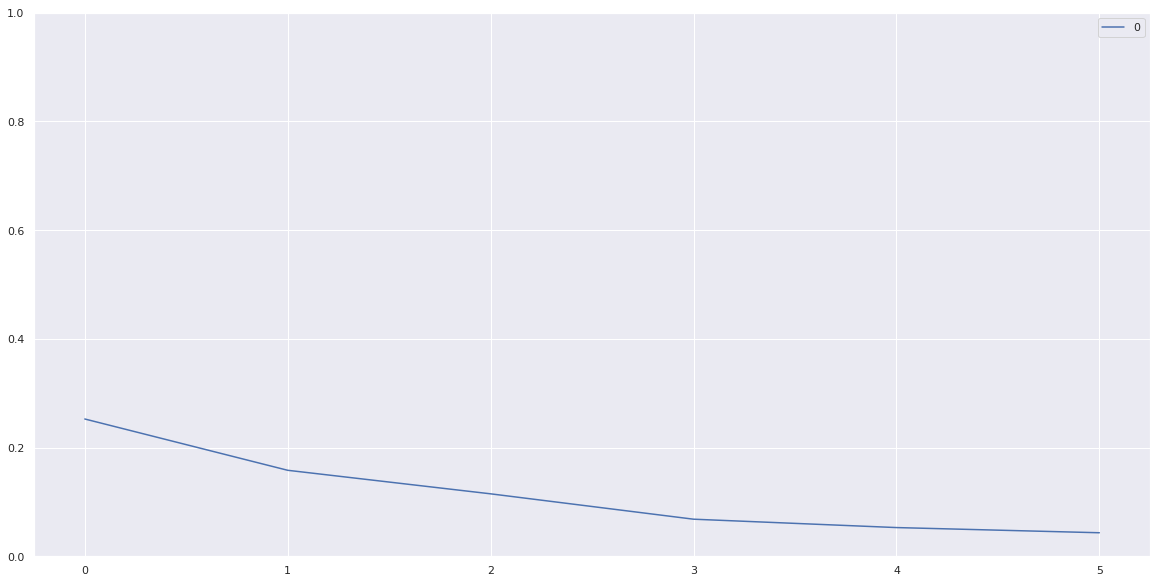

In [9]:
pd.DataFrame(fullscene_pca_model.explained_variance_ratio_).plot(ylim=[0,1])
print("Cumulative explained variance: %s" % fullscene_pca_model.explained_variance_ratio_.cumsum())

### Plotting of the embeding

`plot_embedding` plots each questionnaire's response when projected along the first 2 eigenvectors. Responses' colours correspond to the clips.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

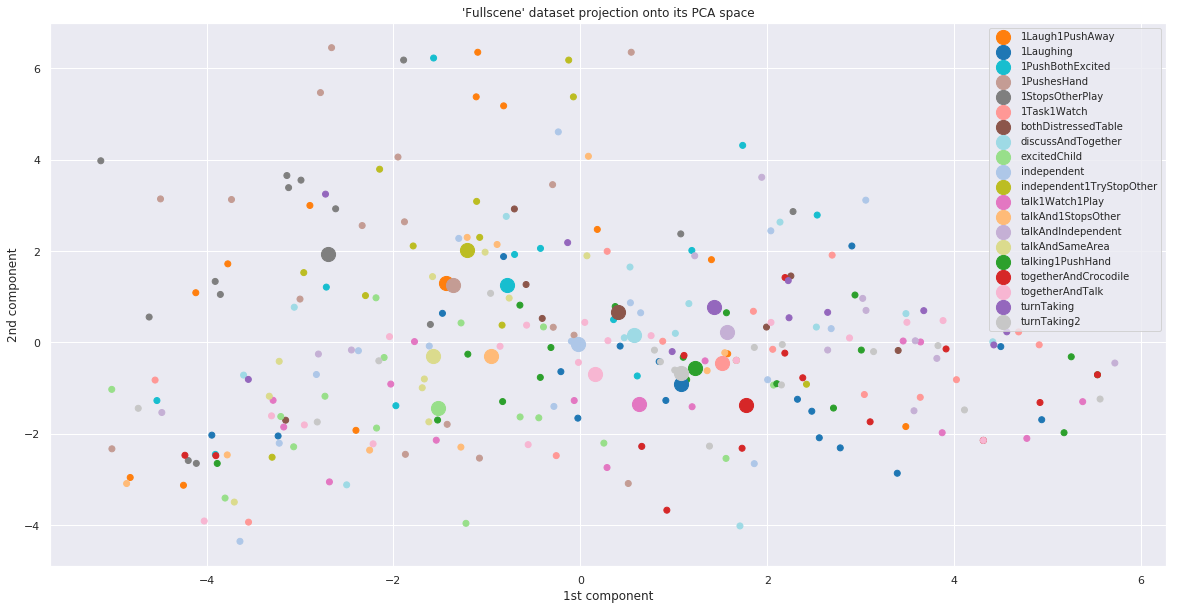

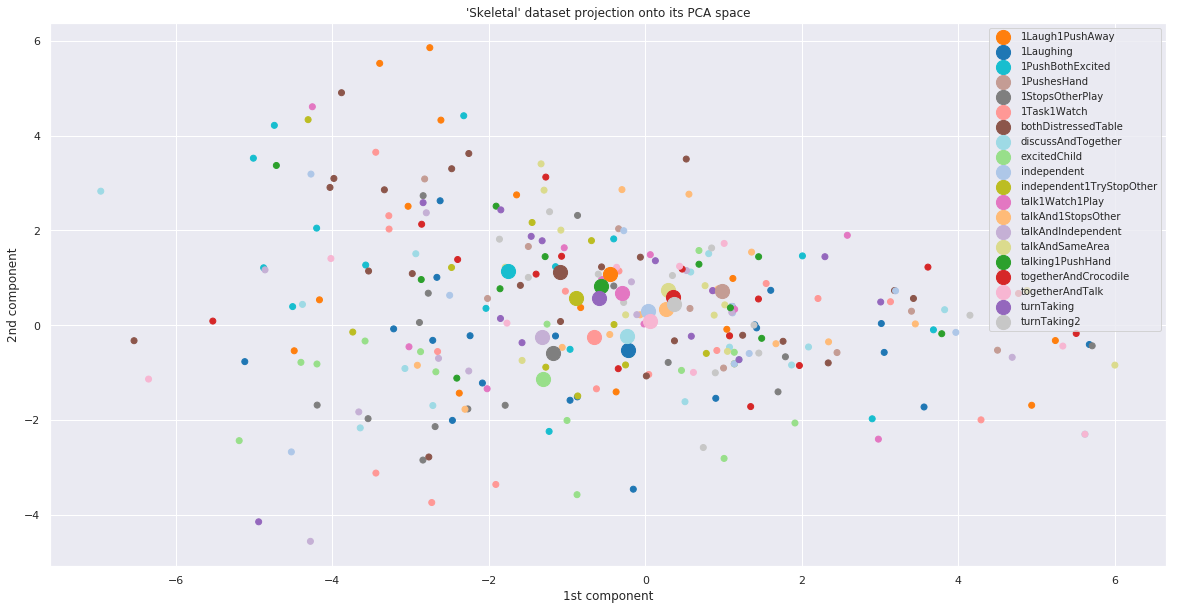

In [10]:
plot_embedding(fullscene_pca, fullscene_labels, fullscene_means_pca, fullscene_means.index, title="'Fullscene' dataset projection onto its PCA space", three_d=False)
plot_embedding(skel_pca, skel_labels, skel_means_pca, skel_means.index, title="'Skeletal' dataset projection onto its PCA space", three_d=False) 

For each clip, we can then plot the distance between its embedding based on fullscene ratings vs its embedding based on skeletal data only.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

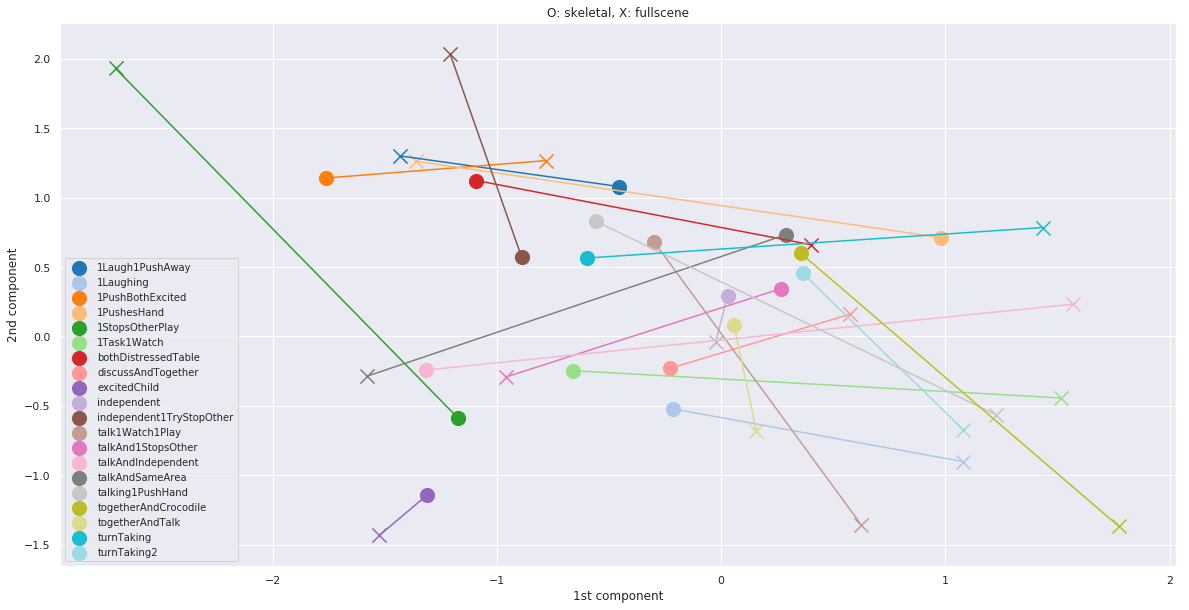

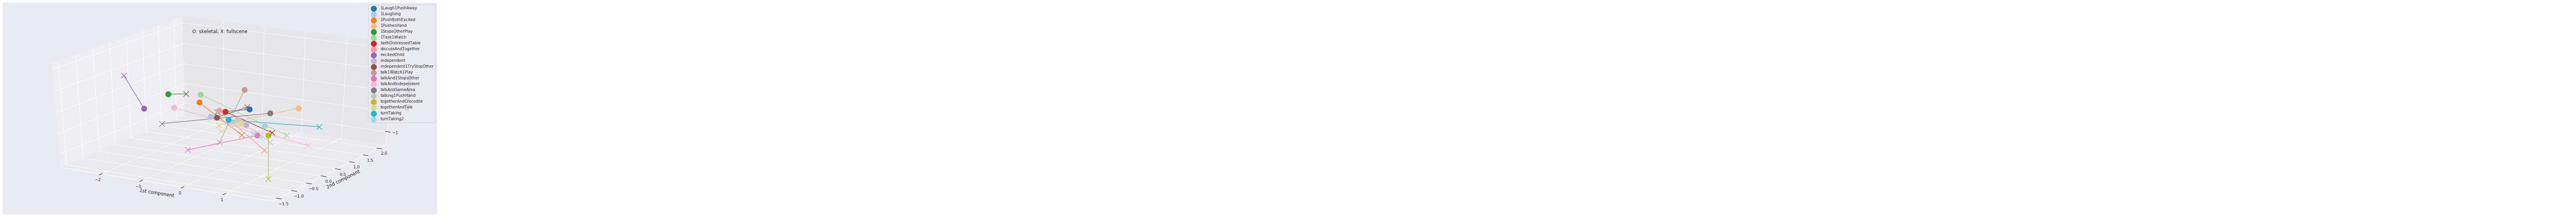

In [11]:
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index, title="O: skeletal, X: fullscene", three_d=False)
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index, title="O: skeletal, X: fullscene", three_d=True)

Computing the actual distance between clips in the two conditions shows that they are generally quite far apart. A straightforward PCA embedding does not seem to be effective to evidence similarities between our 2 conditions.

In [12]:
distances_pca=pd.DataFrame(np.power(np.sum(np.power(skel_means_pca - fullscene_means_pca, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_pca"])
show_heatmap(distances_pca, cmap="summer_r")

,distance_pca
clipName,
1Laugh1PushAway,1.92953
1Laughing,1.49327
1PushBothExcited,2.20443
1PushesHand,3.19782
1StopsOtherPlay,3.65733
1Task1Watch,2.79491
bothDistressedTable,2.42239
discussAndTogether,2.33071
excitedChild,1.72344


To answer the question: *does a PCA evidence common latent factors between our 2 conditions?*, we compute a PCA model *based on the skeletal data*, and compare the resulting PCA components with the ones found with the fullscene data.

We observe that the resulting loadings look very different.

In [13]:
# plot of PCA components, with fullscene vs skeleton components side-by-side


skel_pca_model=PCA(n_components=nb_components).fit(skel)

skel_pca = skel_pca_model.transform(skel)
skel_means_pca = skel_pca_model.transform(skel_means.values)

skel_pca_components = pd.DataFrame(skel_pca_model.components_,columns=constructs).T
fullscene_pca_components = pd.DataFrame(fullscene_pca_model.components_,columns=constructs).T

# merge PCA components into one dataframe, skel and fullscene side-by-side
pca_components=pd.concat([skel_pca_components, fullscene_pca_components], keys=["skel", "fullscene"], axis=1)
pca_components=pca_components.swaplevel(0,1,1).sort_index(1)


show_heatmap(pca_components[abs(pca_components)>0.2], m=-0.6, M=0.6)


/home/s-lemaignan/.local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


## LDA

We perform the LDA *on top of the PCA* as LDA typically requires O > 3 F, with O the nb of observations and F the nb of features (here, we have ~26 observations for originally 22 questions). Using the PCA as a dimensionality reduction tool, we bring down the number of degrees of freedom to 6.

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_nb_components = 4

fullscene_lda_model = LinearDiscriminantAnalysis(n_components=lda_nb_components, solver='svd')
fullscene_lda_model.fit(fullscene_pca, fullscene_labels)

fullscene_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(fullscene))
fullscene_means_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(fullscene_means.values))

skel_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(skel))
skel_means_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(skel_means.values))

Attention: the variance explained by the LDA transformation is the variance in the *PCA* space, not in the original 22-D space of the questionnaire!

In [15]:
print("Cumulative explained variance by LDA: %s" % fullscene_lda_model.explained_variance_ratio_.cumsum())

Cumulative explained variance by LDA: [0.50330235 0.75785615 0.8679825  0.93441839]


When projected in the PDA space, the clips in condition *skeleton* vs *fullscene* are much closer to one another.

In [16]:
distances_lda=pd.DataFrame(np.power(np.sum(np.power(skel_means_lda - fullscene_means_lda, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_lda"])

distances = pd.concat([distances_pca, distances_lda], axis=1)
show_heatmap(distances, cmap="summer_r")


,distance_pca,distance_lda
clipName,,
1Laugh1PushAway,1.92953,1.39128
1Laughing,1.49327,0.699011
1PushBothExcited,2.20443,1.12945
1PushesHand,3.19782,1.7543
1StopsOtherPlay,3.65733,2.28616
1Task1Watch,2.79491,1.56624
bothDistressedTable,2.42239,1.51713
discussAndTogether,2.33071,1.45519
excitedChild,1.72344,1.09196


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

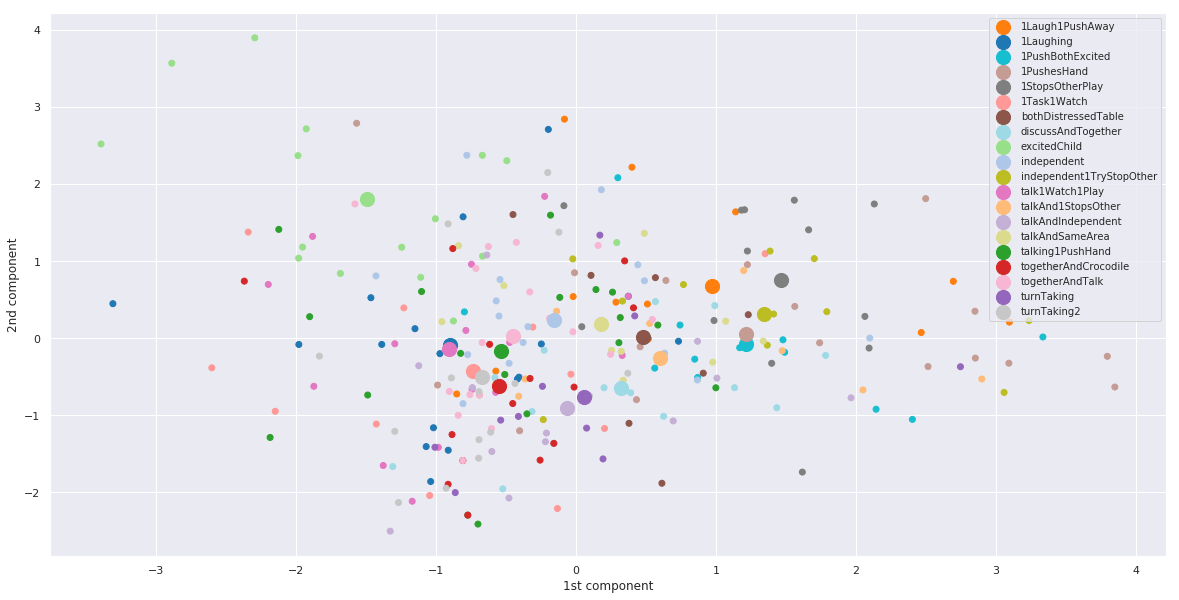

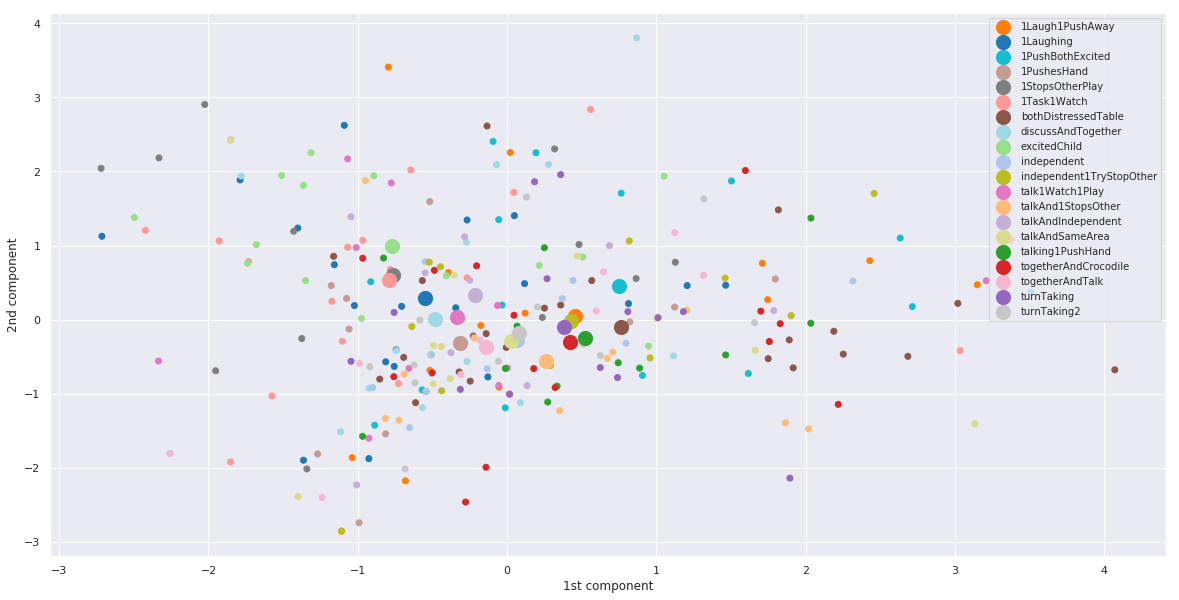

In [17]:
plot_embedding(fullscene_lda, fullscene_labels,fullscene_means_lda, fullscene_means.index, three_d=False)
plot_embedding(skel_lda, skel_labels,skel_means_lda, skel_means.index, three_d=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

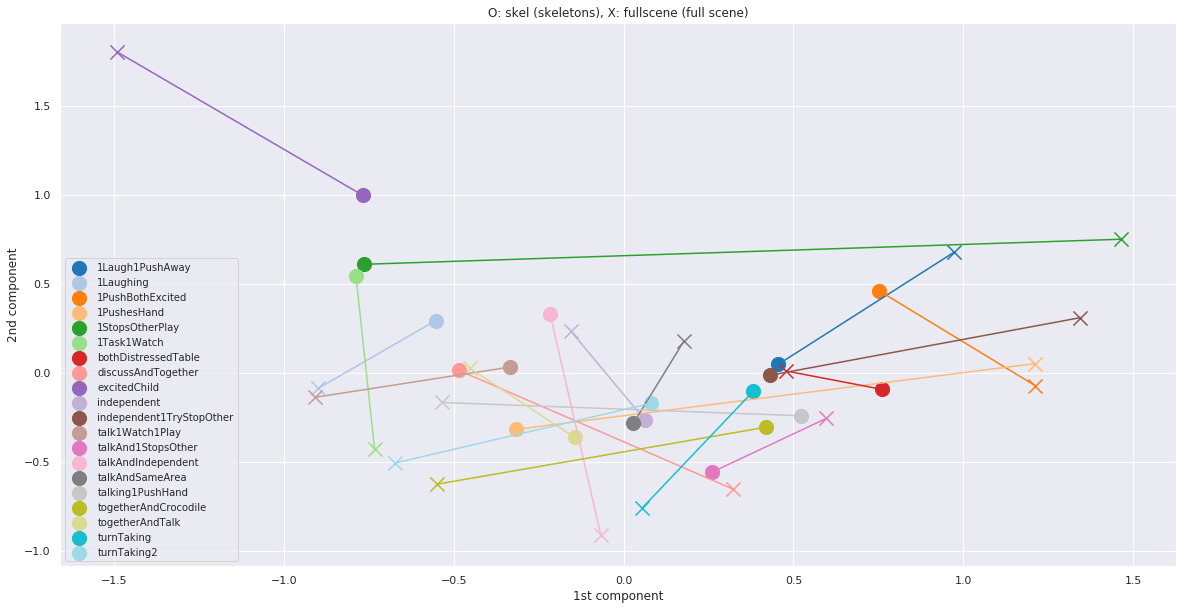

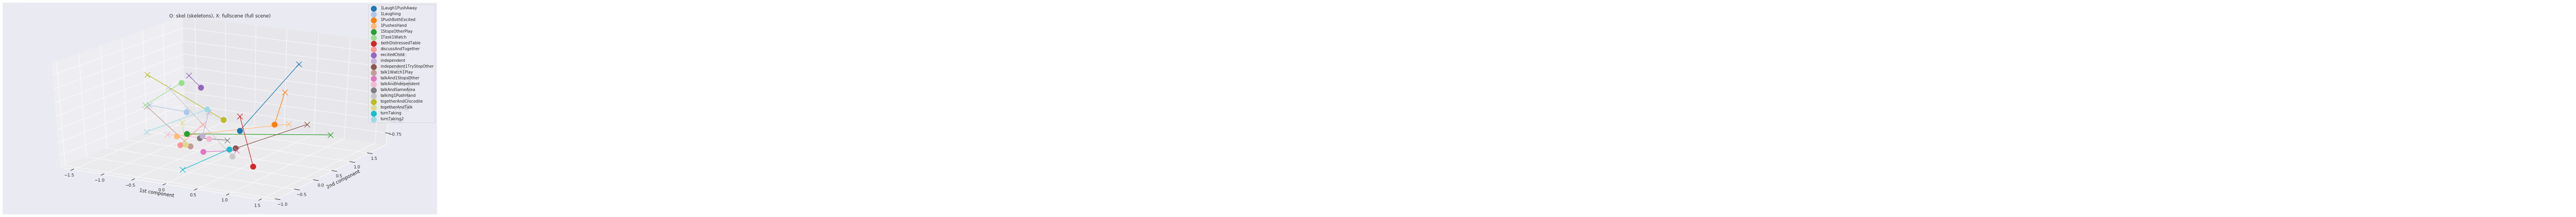

In [18]:
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, fullscene_means.index,three_d=False)
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, skel_means.index,three_d=True)

To answer the question: *does a PCA evidence common latent factors between our 2 conditions?*, we can again create a new LDA model for the skeletal data, and print out the LDA components for *fullscene* vs *skeleton* side-by-side.

We observe that they still look very different.

In [19]:
# compute as well a LDA model from the skeletal PCA to compare components with fullscene
skel_lda_model = LinearDiscriminantAnalysis(n_components=lda_nb_components, solver='svd')
skel_lda_model.fit(skel_pca, skel_labels)


fullscene_lda_components = pd.DataFrame(fullscene_lda_model.scalings_[:,:lda_nb_components].T).T
skel_lda_components = pd.DataFrame(skel_lda_model.scalings_[:,:lda_nb_components].T).T

# merge PCA components into one dataframe, skel and fullscene side-by-side
lda_components=pd.concat([fullscene_lda_components, skel_lda_components], keys=["fullscene", "skel"], axis=1)
lda_components=lda_components.swaplevel(0,1,1).sort_index(1)

show_heatmap(lda_components[abs(lda_components)>0.2], m=-0.6, M=0.6)

/home/s-lemaignan/.local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


By multiplying the LDA loadings matrix with the PCA loadings matrix, we can compute the LDA loadings in terms of the original questions asked to the participants.

In [20]:
lda_loadings=pd.DataFrame(np.dot(fullscene_pca_components, fullscene_lda_components), index=pca_components.index, columns=["LDA component %d" % (i+1) for i in range(lda_nb_components)])
show_heatmap(lda_loadings[abs(lda_loadings)>0.2], m=-0.6, M=0.6)

/home/s-lemaignan/.local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,LDA component 1,LDA component 2,LDA component 3,LDA component 4
leftDominant,-0.21439,nan,0.2079,nan
rightDominant,0.280382,nan,nan,0.32907
leftCooperative,nan,-0.306836,nan,nan
rightCooperative,nan,nan,nan,nan
leftCompetitive,nan,nan,0.210231,nan
rightCompetitive,0.259529,nan,0.214873,0.205985
leftFriendly,nan,-0.236517,nan,-0.21143
rightFriendly,nan,nan,nan,nan
leftAggressive,nan,0.282968,nan,nan
rightAggressive,0.23941,nan,0.249913,nan


## Explorative Factor Analysis

The Python [factor_analyzer](https://factor-analyzer.readthedocs.io) module is a port of EFA from the R' `psych` package.

In [21]:
import factor_analyzer

rotation = None

nb_factors=6

fa_skel = factor_analyzer.FactorAnalyzer()
fa_skel.analyze(skel_ratings_df, nb_factors, rotation=rotation)
skel_loadings=fa_skel.loadings

fa_fullscene = factor_analyzer.FactorAnalyzer()
fa_fullscene.analyze(fullscene_ratings_df, nb_factors, rotation=rotation)
fullscene_loadings=fa_fullscene.loadings

Comparing the loadings for the *fullscene* vs the *skeletal* only data show that the first two factors are highly correlated. **This shows that, using factor analysis, we have uncovered latent constructs that are used by participants to describe the clips in both *fullscene* and *skeletal-only* conditions**.

In [22]:
# merge loadings into one dataframe, skel and fullscene side-by-side
loadings=pd.concat([fullscene_loadings, skel_loadings], keys=["fullscene","skel"], axis=1)
loadings=loadings.swaplevel(0,1,1).sort_index(1)

from scipy.stats import pearsonr

print("Pearson correlation between factors 'fullscene' vs 'skeletal'")
for i in range(1, nb_factors+1):
    r, p=pearsonr(loadings["Factor%d" % i]["fullscene"].values, loadings["Factor%d" % i]["skel"].values)
    print("Factor %d: r=%f, p=%f" % (i,r,p)) 
    
    
show_heatmap(loadings[abs(loadings)>=0.35])

Pearson correlation between factors 'fullscene' vs 'skeletal'
Factor 1: r=0.976505, p=0.000000
Factor 2: r=0.763261, p=0.000036
Factor 3: r=0.355738, p=0.104200
Factor 4: r=0.889015, p=0.000000
Factor 5: r=-0.800550, p=0.000008
Factor 6: r=-0.725461, p=0.000133


/home/s-lemaignan/.local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [23]:
fa_skel.get_factor_variance()


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,5.804406,2.444733,1.820465,0.954894,0.890181,0.619004
Proportion Var,0.263837,0.111124,0.082748,0.043404,0.040463,0.028137
Cumulative Var,0.263837,0.374961,0.457709,0.501114,0.541576,0.569713


In [24]:
fa_fullscene.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,5.104108,3.007979,2.097653,1.079230,0.866166,0.594469
Proportion Var,0.232005,0.136726,0.095348,0.049056,0.039371,0.027021
Cumulative Var,0.232005,0.368731,0.464079,0.513135,0.552506,0.579527


### EFA embeddings

We can use the EFA space as a 'better' space to represent our clips, where the latent, composite constructs correspond to the main axis:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


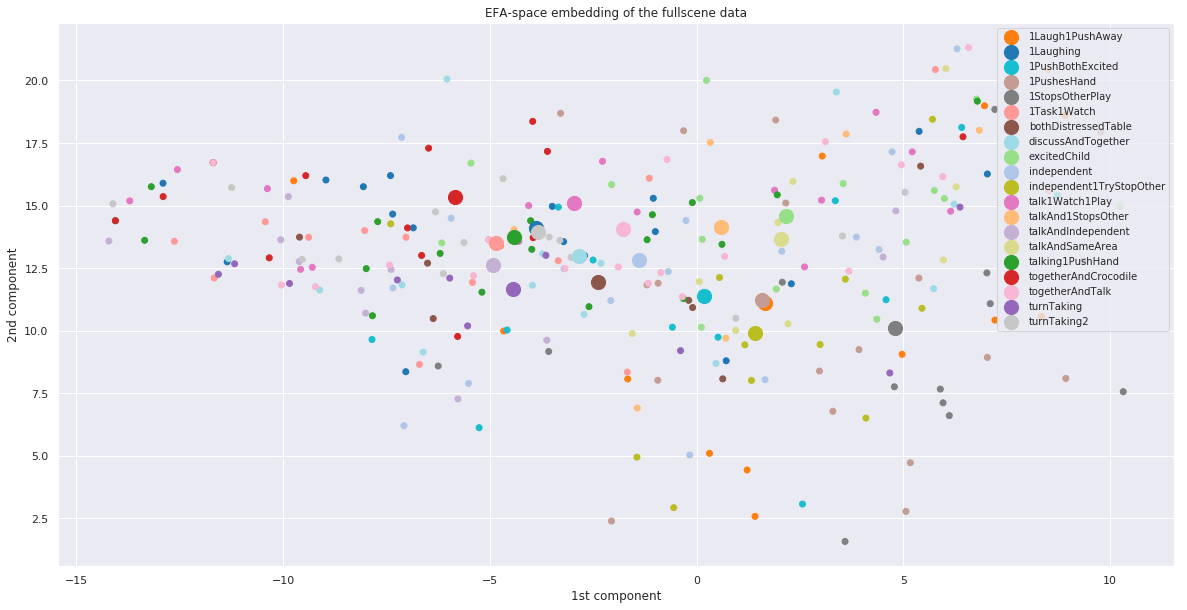

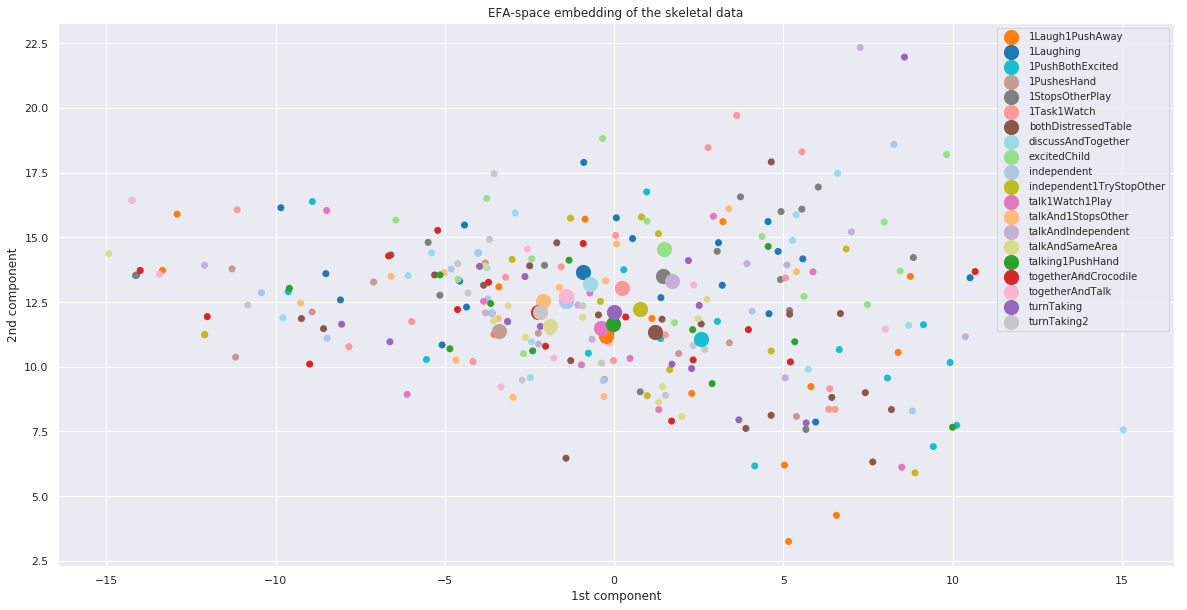

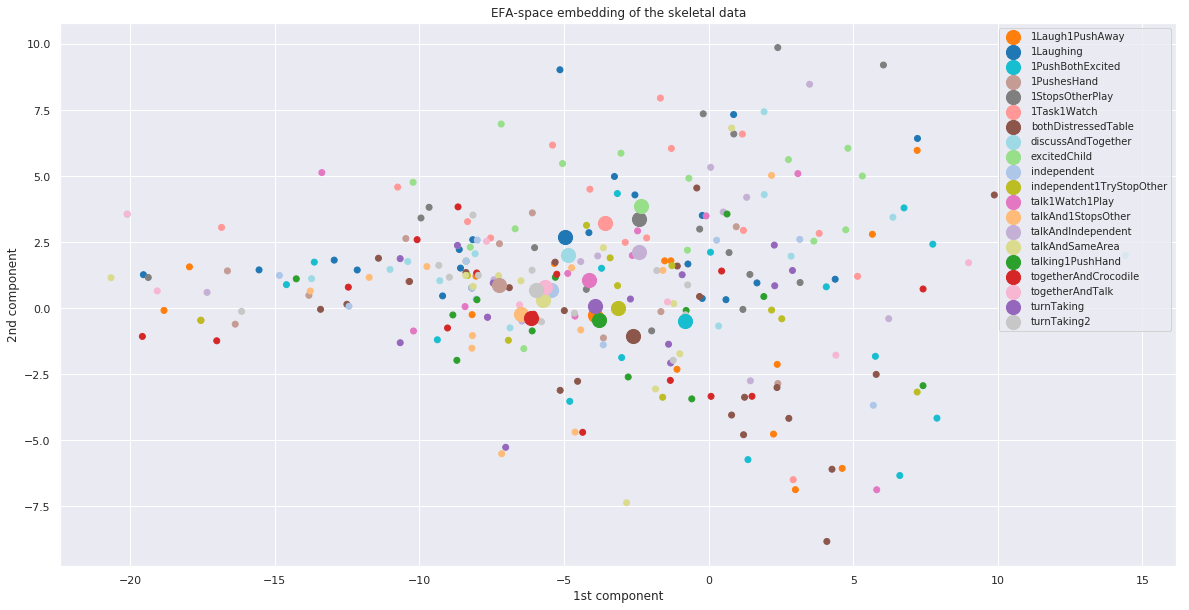

In [25]:
nb_of_factors=2
fullscene_efa = np.dot(fullscene,fullscene_loadings.values[:,:nb_of_factors])
fullscene_means_efa = np.dot(fullscene_means,fullscene_loadings.values[:,:nb_of_factors])
skel_efa = np.dot(skel,fullscene_loadings.values[:,:nb_of_factors])
skel_means_efa = np.dot(skel_means,fullscene_loadings.values[:,:nb_of_factors])

skel_pure_efa = np.dot(skel,skel_loadings.values[:,:nb_of_factors])
skel_pure_means_efa = np.dot(skel_means,skel_loadings.values[:,:nb_of_factors])


plot_embedding(fullscene_efa, fullscene_labels,fullscene_means_efa, fullscene_means.index, title="EFA-space embedding of the fullscene data", three_d=False)
plot_embedding(skel_efa, skel_labels,skel_means_efa, skel_means.index, title="EFA-space embedding of the skeletal data", three_d=False)
plot_embedding(skel_pure_efa, skel_labels,skel_pure_means_efa, skel_means.index, title="EFA-space embedding of the skeletal data", three_d=False)


Interestingly, even if the EFA factors are quite similar, the distances between same clips in fullscene vs skeletal data are higher in the EFA space compared to the PCA or LDA space:

In [26]:
distances_efa=pd.DataFrame(np.power(np.sum(np.power(skel_means_efa - fullscene_means_efa, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_efa"])

distances = pd.concat([distances_pca, distances_lda, distances_efa], axis=1)
print("Mean distances:\n%s" % distances.mean(axis=0))
show_heatmap(distances, cmap="summer_r")


Mean distances:
distance_pca    2.291602
distance_lda    1.224597
distance_efa    3.404622
dtype: float64


,distance_pca,distance_lda,distance_efa
clipName,,,
1Laugh1PushAway,1.92953,1.39128,1.8997
1Laughing,1.49327,0.699011,2.99936
1PushBothExcited,2.20443,1.12945,2.40452
1PushesHand,3.19782,1.7543,5.00109
1StopsOtherPlay,3.65733,2.28616,4.78681
1Task1Watch,2.79491,1.56624,5.12494
bothDistressedTable,2.42239,1.51713,3.65782
discussAndTogether,2.33071,1.45519,2.16195
excitedChild,1.72344,1.09196,0.685324


# Clustering



Based on the distance measurements, the LDA space seems to be the best to cluster our clips.
We can then attempt to cluster our 20 clips into 'groups' of similar clips (based on the latent constructs):

,cluster #
clipName,
talkAndSameArea,0
talkAnd1StopsOther,0
excitedChild,0
turnTaking2,1
1Laughing,1
togetherAndCrocodile,1
talking1PushHand,1
1Task1Watch,1
talkAndIndependent,1


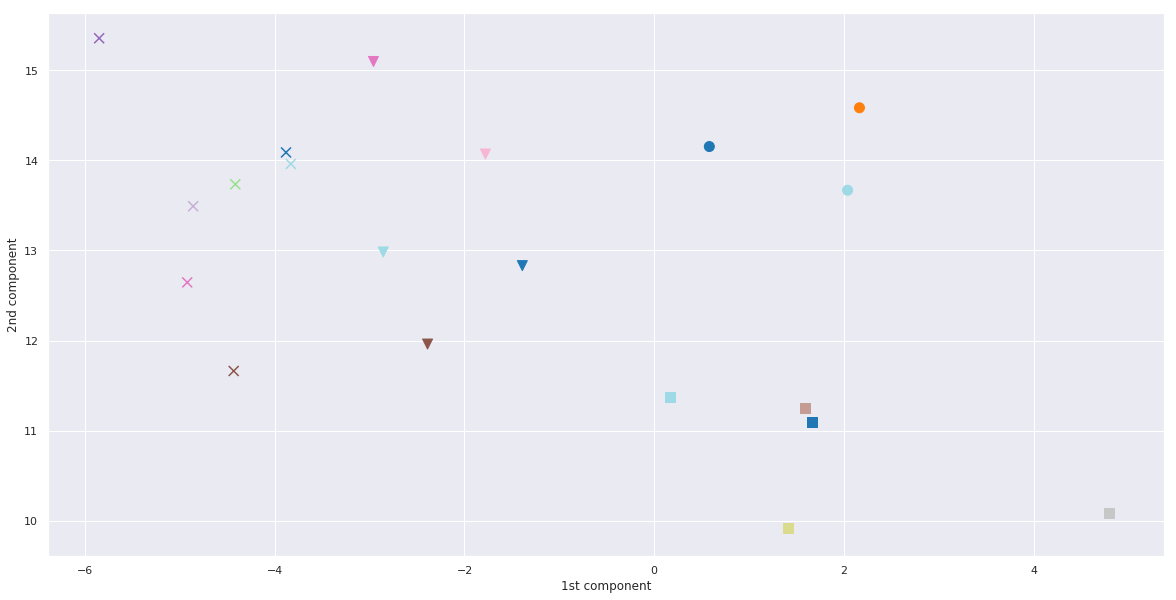

In [27]:
from sklearn.cluster import KMeans

# kMeans clustering after projecting our clips in the EFA-space
fullscene_clustering_data=fullscene_means_efa

nb_clusters=4

fullscene_kmeans_model = KMeans(n_clusters=nb_clusters, random_state=0).fit(fullscene_clustering_data)
fullscene_kmeans = fullscene_kmeans_model.predict(fullscene_clustering_data)

plot_embedding(fullscene_clustering_data,fullscene_means.index,clusters=fullscene_kmeans, three_d=False)

pd.DataFrame(fullscene_kmeans, index=fullscene_means.index, columns=["cluster #"]).sort_values(by="cluster #")

We should be able to infer the semantics of the 3 first EFA factors.


We can then try to predict in which cluster the clips would end up, using only the ratings from the skeletal videos:

In [28]:
skel_means_efa.shape

(20, 2)

7 skeleton clips out of 20 (35.0%) are predicted to fall into the same cluster as their 'fullscene' counterpart.


,fullscene clusters,skel clusters,same,kripp alpha std,kripp alpha mean,alpha(fullscene),alpha(skel)
clipName,,,,,,,
1StopsOtherPlay,2,0,False,0.0451695,0.153369,0.185309,0.12143
1Laugh1PushAway,2,2,True,0.0132579,0.201999,0.211374,0.192624
excitedChild,0,0,True,0.0469299,0.204329,0.237514,0.171145
talkAndSameArea,0,3,False,0.109427,0.228745,0.151368,0.306122
independent1TryStopOther,2,2,True,0.0914231,0.233003,0.297648,0.168357
togetherAndTalk,3,3,True,0.0682546,0.248172,0.296435,0.199909
1Task1Watch,1,0,False,0.14138,0.25163,0.351601,0.151658
talkAndIndependent,1,0,False,0.268835,0.265307,0.455402,0.075212
talk1Watch1Play,3,2,False,0.156148,0.265873,0.376286,0.15546


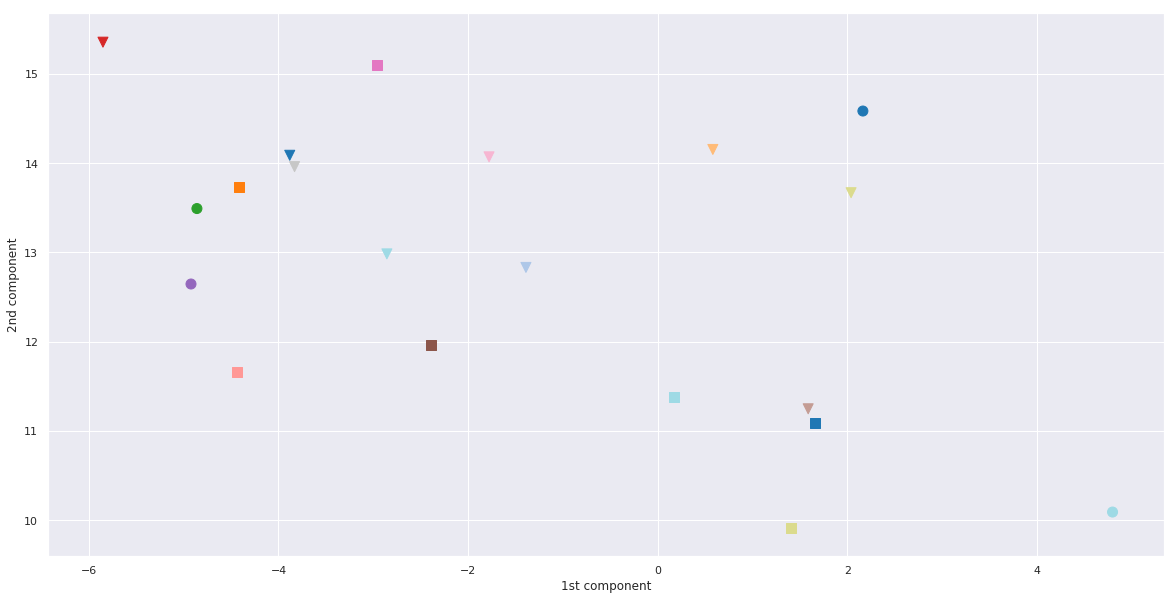

In [29]:
skel_kmeans= fullscene_kmeans_model.predict(skel_means_efa)

plot_embedding(fullscene_means_efa,skel_means.index, clusters=skel_kmeans, three_d=False)

diff=pd.DataFrame(fullscene_kmeans-skel_kmeans,index=skel_means.index)
print("%d skeleton clips out of %d (%.1f%%) are predicted to fall into the same cluster as their 'fullscene' counterpart." % (diff[diff==0].count(), skel_kmeans.size, diff[diff==0].count() * 100. / skel_kmeans.size))

clusters_kripp=pd.DataFrame([fullscene_kmeans, skel_kmeans, fullscene_kmeans==skel_kmeans,krippendorff_df[["alpha(fullscene)", "alpha(skel)"]].std(axis=1).astype(float), krippendorff_df[["alpha(fullscene)", "alpha(skel)"]].mean(axis=1).astype(float), krippendorff_df["alpha(fullscene)"], krippendorff_df["alpha(skel)"], ],index=["fullscene clusters", "skel clusters", "same", "kripp alpha std", "kripp alpha mean", "alpha(fullscene)", "alpha(skel)"],columns=skel_means.index).T.sort_values(by="kripp alpha mean")
clusters_kripp

# Classification

Using a SVM classifier, we can try to improve our predictions:

In [30]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')

# trying with skel, skel_pca, skel_lda do not lead to any clear improvements
training_set = fullscene_means_efa
training_labels = fullscene_kmeans

testing_set = skel_means_efa
# Critically, we are testing with the *fullscene_kmeans* as we want to check whether 
# we predict the same clusters as with the fullscene stimuli.
testing_labels = fullscene_kmeans

clf.fit(training_set, training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
for p, l in zip(clf.predict(testing_set), testing_labels):
    print("%s (should be %s)" % (p,l))
print("SVM: %.1f%% successful prediction out of %d tested clips" % (clf.score(testing_set, testing_labels) * 100, len(testing_labels)))

2 (should be 2)
3 (should be 1)
2 (should be 2)
1 (should be 2)
0 (should be 2)
0 (should be 1)
2 (should be 3)
3 (should be 3)
0 (should be 0)
3 (should be 3)
2 (should be 2)
2 (should be 3)
3 (should be 0)
0 (should be 1)
3 (should be 0)
2 (should be 1)
3 (should be 1)
3 (should be 3)
2 (should be 1)
3 (should be 1)
SVM: 35.0% successful prediction out of 20 tested clips


Confusion matrix, without normalization


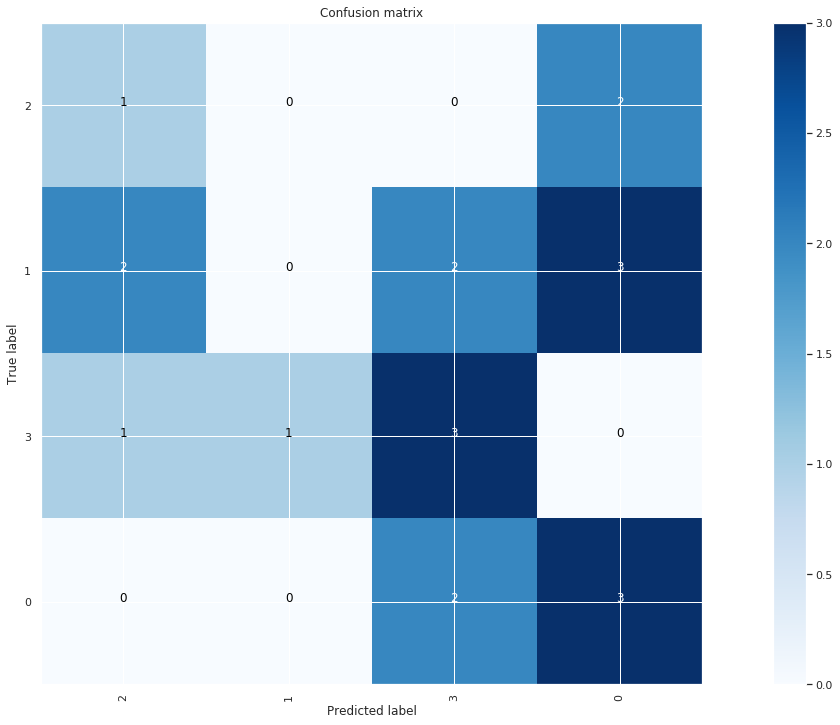

In [32]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(testing_labels, clf.predict(testing_set))
plot_confusion_matrix(cnf_matrix, classes=pd.unique(testing_labels))